## Intro

Welcome to the synthetic earth model builder + elastic wave propagation tutorial. The git repositories, with installation instructions, can be found at [here](http://cees-gitlab.stanford.edu/SEP-external/syntheticModel) and [here](https://github.com/biondiettore/elastic_isotropic_operators). This will be a short tutorial on how to build 3d earth models and how to create seismic data with the 2d elastic, isotropic wave equation gpu code.

In [1]:
# add to environment variables
elastic_install = '/sep/stuart/packages/elastic_isotropic_operators/local/'
os.environ['PATH'] = elastic_install + 'bin:' + os.environ['PATH']
os.environ['PYTHONPATH'] = elastic_install + 'lib/python3.6:' + os.environ['PYTHONPATH']
os.environ['LD_LIBRARY_PATH'] = elastic_install + 'lib:' + os.environ['LD_LIBRARY_PATH']

geomodel_install = '/sep/stuart/packages/syntheticModel_new/local/'
os.environ['PATH'] = geomodel_install + 'bin:' + os.environ['PATH']
os.environ['PYTHONPATH'] = geomodel_install + 'lib/python3.6:' + os.environ['PYTHONPATH']
os.environ['LD_LIBRARY_PATH'] = geomodel_install + 'lib:' + os.environ['LD_LIBRARY_PATH']

# Importing some of the necessary modules
import os 
import matplotlib.pyplot as plt 
import genericIO
import numpy as np
import math

# Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)

NameError: name 'os' is not defined

# Part One: A library for building earth models
Whether you want a simple pressure-wave model or a complex 3D elastic, anisotropic, dispersive model, the earth model builder is the tool for you. The first part of this notebook will introduce you to python module and how to build your first model. 

Import the syntheticModel modules. Inspect the __init__ function to see how we initialize a new model.

In [19]:
import syntheticModel

?syntheticModel.geoModel.__init__

So we need a Hypercube describing the initial model, a dictionary of properties with their basement values, and string defining the primary property.

In [20]:
import Hypercube

# make a hypercube 
nx,ox,dx = 1000, 0, 5
ny,oy,dy = 1000, 0, 5
nz,oz,dz = 30, 0, 5
x_axis = Hypercube.axis(n=nx, o=ox, d=dx)
y_axis = Hypercube.axis(n=ny, o=oy, d=dy)
z_axis = Hypercube.axis(n=nz, o=oz, d=dz)
hyper = Hypercube.hypercube(axes=[z_axis,y_axis,x_axis])

# make a dictionary of elastic parameters 
basement = {"vp":3000, "vs":2000, "rho": 2000}

# set the primary value 
primary = "vp"

# initialize the geomodel
geomodel = syntheticModel.geoModel(hyper,basement,primary)

We have initialized a model! How do we look at the individual properties? Look at the __get__ function.

In [21]:
?syntheticModel.geoModel.get

Extract and plot each parameter

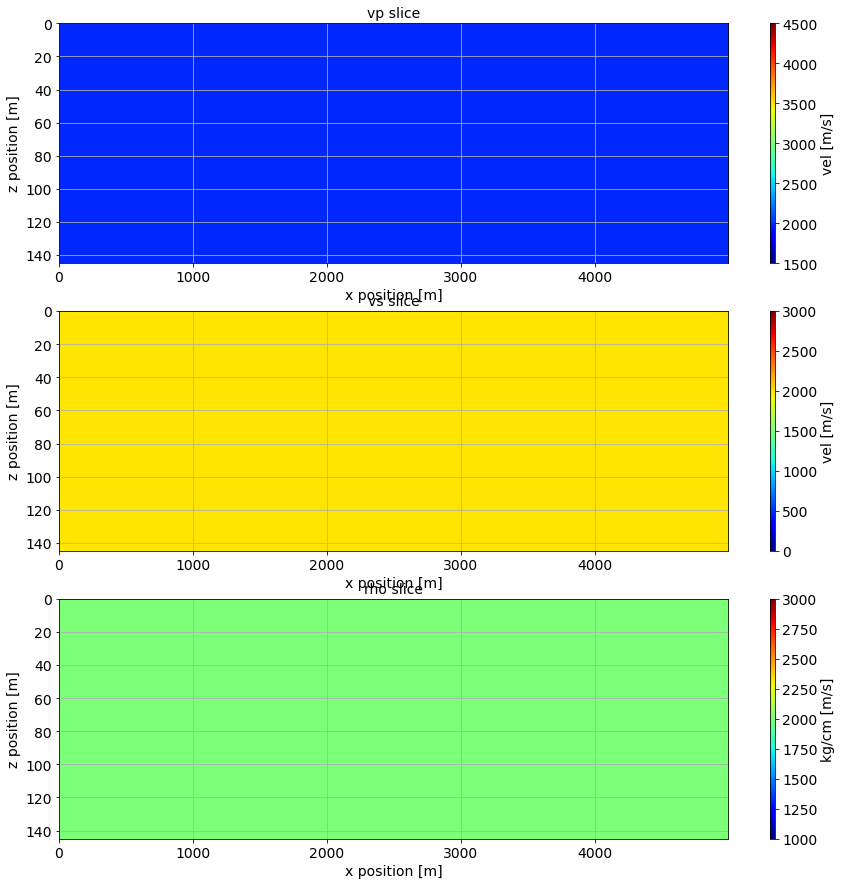

In [22]:
# extract a SepVector for each parameters
vp_param_sepvector = geomodel.get('vs')
vs_param_sepvector = geomodel.get('vs')
rho_param_sepvector = geomodel.get('vs')

plt.figure(figsize=(15,15))

plt.subplot(3,1,1), plt.title("vp slice")
plt.imshow(vp_param_sepvector.getNdArray()[:,50,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, oz+(nz-1)*dz, oz),
           interpolation="spline16",vmin=1500,vmax=4500,cmap='jet')
plt.xlabel("x position [m]"), plt.ylabel("z position [m]")
plt.colorbar(orientation="vertical", label="vel [m/s]", aspect=50)
ax = plt.gca()
ax.grid()

plt.subplot(3,1,2), plt.title("vs slice")
plt.imshow(vs_param_sepvector.getNdArray()[:,50,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, oz+(nz-1)*dz, oz),
           interpolation="spline16",vmin=0,vmax=3000,cmap='jet')
plt.xlabel("x position [m]"), plt.ylabel("z position [m]")
plt.colorbar(orientation="vertical", label="vel [m/s]", aspect=50)
ax = plt.gca()
ax.grid()

plt.subplot(3,1,3), plt.title("rho slice")
plt.imshow(rho_param_sepvector.getNdArray()[:,50,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, oz+(nz-1)*dz, oz),
           interpolation="spline16",vmin=1000,vmax=3000,cmap='jet')
plt.xlabel("x position [m]"), plt.ylabel("z position [m]")
plt.colorbar(orientation="vertical", label="kg/cm [m/s]", aspect=50)
ax = plt.gca()
ax.grid()

Lets make a function to make plotting easier in the future.

In [23]:
def plot_geomodel(geomodel,params,slice=50):
    n_params= len(params)
    
    plt.figure(figsize=(15,15))
    primary_param_hyper = geomodel.get().getHyper()
    nz,oz,dz = primary_param_hyper.getAxis(1).n, primary_param_hyper.getAxis(1).o, primary_param_hyper.getAxis(1).d
    nx,ox,dx = primary_param_hyper.getAxis(3).n, primary_param_hyper.getAxis(3).o, primary_param_hyper.getAxis(3).d
    
    for i, param in enumerate(params):
        plt.subplot(n_params,1,i+1), plt.title(param)
        
        minClipVal = np.amin(geomodel.get(param).getNdArray()[:,slice,:].T)
        maxClipVal = np.amax(geomodel.get(param).getNdArray()[:,slice,:].T)
        
        plt.imshow(geomodel.get(param).getNdArray()[:,slice,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, oz+(nz-1)*dz, oz),
                   vmin=minClipVal,vmax=maxClipVal,cmap='jet')
#         plt.imshow(geomodel.get(param).getNdArray()[:,slice,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, oz+(nz-1)*dz, oz),
#                    interpolation="spline16",vmin=1500,vmax=4500)
        plt.xlabel("x position [m]"), plt.ylabel("z position [m]")
        plt.colorbar(orientation="vertical", aspect=50)
        ax = plt.gca()
        ax.grid()

The model builder works by performing geologic 'events'. Those events could be deposition, faulting, compression, erosion, or salt emplacement. Let's look at how to perform a deposition event.

In [24]:
?geomodel.fault

In [25]:
import SepVector

#?syntheticModel.geoModel.deposit

geomodel = syntheticModel.geoModel(hyper,basement,primary)

# geomodel.deposit(prop=3000, interbedThick=30, interbedPropVar=200, vp_var=0.03)

# geomodel.deposit(thick=400, prop=1500, interbedThick=100, interbedThickVar=33, interbedPropVar=100, vp_var=0.1, depthGrad=15)
# geomodel.deposit(thick=400, prop=1500, interbedThick=500, interbedThickVar=100, interbedPropVar=200, vp_var=0.05, vs_var=0.05, rho_var=0.05,depthGrad=15)
# geomodel.deposit(thick=400, prop=1500, interbedThick=400, interbedThickVar=100, interbedPropVar=200, depthGrad=15)
geomodel.deposit(thick=400, prop=1500, interbedThick=400, 
                 interbedThickVar=100, interbedPropVar=200, 
                 vp_var=0.05, vs_var=0.05, rho_var=0.05,
                 vs_ratio=0.5,rho_ratio=0.75,
                 depthGrad=15)

# squish the model, adding folds
# geomodel.squish()
geomodel.squish(widthInline=200,widthCrossline=200,max=100)

# fault
fault_kw = {}
fault_kw['xpos'] = int((nx*dx)/2)
fault_kw['ypos'] = int((ny*dy)/2)
fault_kw['zpos'] = 1000
fault_kw['azimuth'] = 90
#rupture params
fault_kw['ruptureLength'] = 300
fault_kw['extentInline'] = 2*fault_kw['ruptureLength']
fault_kw['extentCrossline'] = 2*fault_kw['ruptureLength']
fault_kw['shift'] = 0.25*fault_kw['ruptureLength']
fault_kw['angle'] = 15#/180*np.pi
fault_kw['radiusFreq'] = 1
fault_kw['radius'] = 2000

geomodel.fault(**fault_kw)

# add a water column
# geomodel.deposit(thick=50, prop=1500, interbedThick=50, interbedThickVar=0, interbedPropVar=0, vs_ratio=0, rho_ratio=(1000/1500), vp_var=0.0, vs_var=0, rho_var=0)

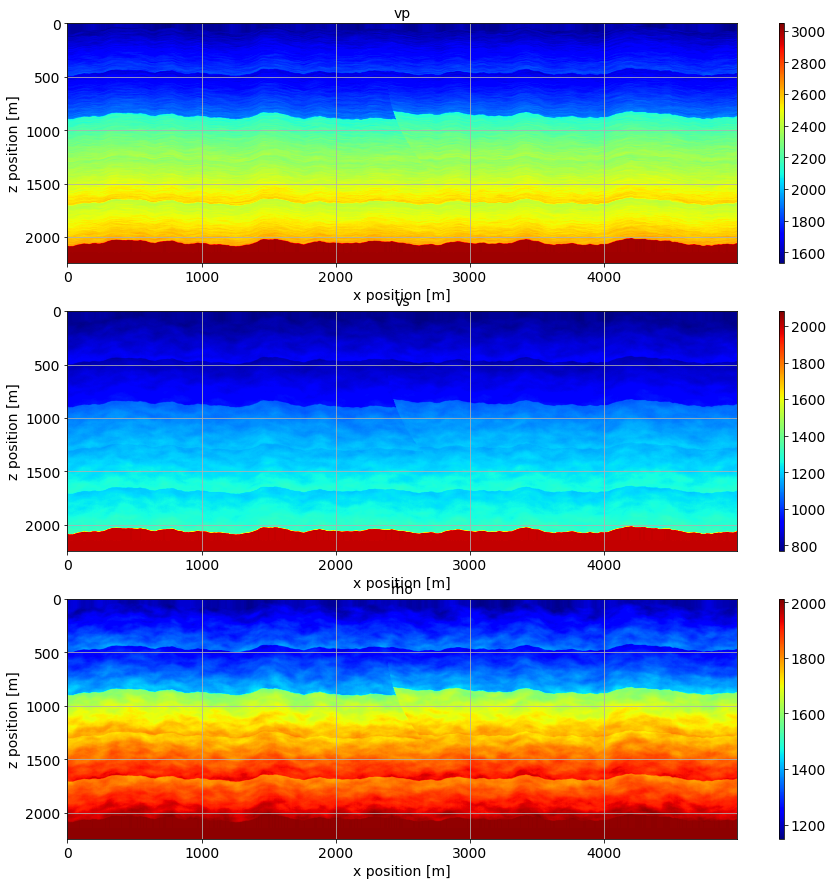

In [26]:
plot_geomodel(geomodel,basement,slice=int(nx/2))

# Part Two: Making elastic data
Now that you can make elastic models, lets make some seismic data with an elastic wave equation code. 

We need to make:
- a source function
- a padded elastic model
- a string of parameters

Make Ricker source function

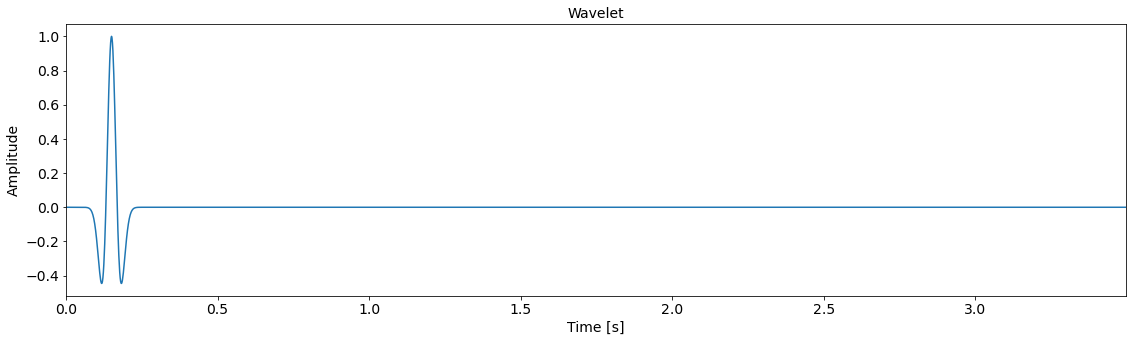

max frequency: 47.43534790684383


In [27]:
# set time domain variables
max_t = 3.5
ot, dts, timeDelay = 0.0, 0.0015, 0.15
nts = int(max_t/dts)
fDom = 12
wavelet_filename = 'ricker.H'

# run shell command to make wavelet
!waveletFloatMain.py dts={dts} nts={nts} fDom={fDom} type=ricker wavelet={wavelet_filename} timeDelay={timeDelay}

#read in and plot wavelet
wavelet_sep = genericIO.defaultIO.getVector(wavelet_filename)

#plot the wavelet
fig,ax=plt.subplots(figsize=(19,5))
time_range = np.linspace(ot,ot+(nts-1)*dts,nts)
plt.plot(np.linspace(ot,ot+(nts-1)*dts,nts), wavelet_sep.getNdArray())
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.show()

# find the max frequency. Needed for to avoid dispersion
freq = np.fft.rfftfreq(nts,dts)
vec2_fft = np.fft.rfft(wavelet_sep.getNdArray())
fmax = np.amax(np.argwhere(vec2_fft>0.0001))*(freq[1]-freq[0])
print(f'max frequency: {fmax}')

# make five component explosive source 
wavelet_explosive_sep = SepVector.getSepVector(Hypercube.hypercube(axes=[wavelet_sep.getHyper().getAxis(1),Hypercube.axis(n=5,o=0,d=1)]))
wavelet_explosive_sep.getNdArray()[0,...] *= 0
wavelet_explosive_sep.getNdArray()[1,...] *= 0 
wavelet_explosive_sep.getNdArray()[2,...] = wavelet_sep.getNdArray()
wavelet_explosive_sep.getNdArray()[3,...] = wavelet_sep.getNdArray()
wavelet_explosive_sep.getNdArray()[4,...] *= 0 
wavelet_explosive_filename = 'wavelet_explosive.H'
wavelet_explosive_sep.writeVec(wavelet_explosive_filename)

Window the 3d model and pad with absorbing boundary

In [28]:
# get the elastic parameters from the geomodel
elasticModel_3d = geomodel.getSepVector()

# window out a 2d slice
elasticModel_2d = elasticModel_3d.window(n2=1,f2=1)

# write the 2d slice to disk 
elasticModel_2d_filename = 'elasticModel.H'
elasticModel_2d.writeVec(elasticModel_2d_filename)

# # Pad elastic model
elasticModel_2d_padded_filename = 'elasticModel.pad.H'
!Window3d n2=1 < {elasticModel_2d_filename} > temp.H
std_out = !padElasticFileGpuMain.py zPad=100 xPad=100 model=temp.H data={elasticModel_2d_padded_filename} fat=4

In [29]:
# get size of padded model from std_out of padding command 
print(std_out)
param_dict = {}
param_dict['nts'] = nts  #Number of time samples
param_dict['dts'] = dts  #Coarse sampling [s]
param_dict['sub'] = 4 #Ratio between coarse and propagation samplings
param_dict['dz'] = dz     #Sampling of z direction [m]
param_dict['dx'] = dx     #Sampling of x direction [m]
param_dict['fMax'] = fmax   #Maximum propagated frequency [Hz]

# check dispersion and set 'sub' so we obey courant conditions 
elasticModel_2d_nd = elasticModel_2d.getNdArray()[:2,...]
elasticModel_2d_nd_g0 = elasticModel_2d_nd[elasticModel_2d_nd>0]
velmin = np.amin(elasticModel_2d_nd_g0)
velmax = np.amax(elasticModel_2d.getNdArray()[:2,...])
dispersion = velmin / fmax / max(dx,dz)
courant = 0.45
dtw = courant * min(dx,dz) / velmax
sub = math.ceil(dts / dtw) + 1
param_dict['sub'] = sub #Ratio between coarse and propagation samplings

#The following numbers are provided when the model is padded
param_dict['nz'] = int([match for match in std_out if "New nz" in match][0].split()[3]) #Number of samples in the z direction
param_dict['nx'] = int([match for match in std_out if "New nx" in match][0].split()[3]) #Number of samples in the x direction
param_dict['zPadMinus'] = int([match for match in std_out if "zPadMinus" in match][0].split()[2])
param_dict['zPadPlus'] = [match for match in std_out if "zPadPlus" in match][0].split()[2]
param_dict['xPadMinus'] = [match for match in std_out if "xPadMinus" in match][0].split()[2]
param_dict['xPadPlus'] = [match for match in std_out if "xPadPlus" in match][0].split()[2]
param_dict['fat'] = 4
param_dict['mod_par'] = 1

#Source geometry
param_dict['nExp'] = 5 #Number of shots
# param_dict['nShot'] = 5 
param_dict['xSource'] = 1
param_dict['spacingShots'] = int(nx/(param_dict['nExp']-1))
param_dict['zSource'] = 3

#Receiver geometry
param_dict['nReceiver']=nx-1 #Number of receivers
param_dict['depthReceiver']=1   #Receivers' depth
param_dict['oReceiver']=0 #X position of the first receiver
param_dict['dReceiver']=1 #Receiver interval

#GPU related variables
#nGpu=1 #Number of GPU cards to parallelize over shots
param_dict['iGpu'] = [1,2,3] #GPU-card IDs to parallelize over shots (it can be a comma-separated list). Overwrites nGpu!
param_dict['blockSize'] = 16  #BlockSize of GPU grid
param_dict['info'] = 0 #Verbosity
param_dict['mod_par'] = 1

# turn the dictionary into a string so we can pass it to a shell command
param_dict_to_string = ' '.join([str(key)+'='+str(value) for key,value in param_dict.items()])

[' ', '------------------------ Model padding program --------------------', 'Chosen surface condition parameter: ', '(0) no free surface condition ', '', 'Original nz =  450  [samples]', 'Original nx =  1000  [samples]', ' ', 'zPadMinus =  100  [samples]', 'zPadPlus =  106  [samples]', 'xPadMinus =  100  [samples]', 'xPadPlus =  100  [samples]', ' ', 'blockSize =  16  [samples]', 'FAT =  4  [samples]', ' ', 'New nz =  664  [samples including padding and FAT]', 'New nx =  1208  [samples including padding and FAT]', '-------------------------------------------------------------------', ' ']


Run the wave propagation code

In [30]:
# Running non-linear operator to generate acoustic data
elastic_data_filename = 'elastic_data.H'
!nonlinearPythonElasticFloatMain.py {param_dict_to_string} model={wavelet_explosive_filename} elasticParam={elasticModel_2d_padded_filename} data={elastic_data_filename} #info=0 par=parFWI.p

-------------------------------------------------------------------
------------------ Running Python nonlinear forward ---------------
-------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------



In [31]:
#read in elastic data
data_sep = genericIO.defaultIO.getVector(elastic_data_filename)

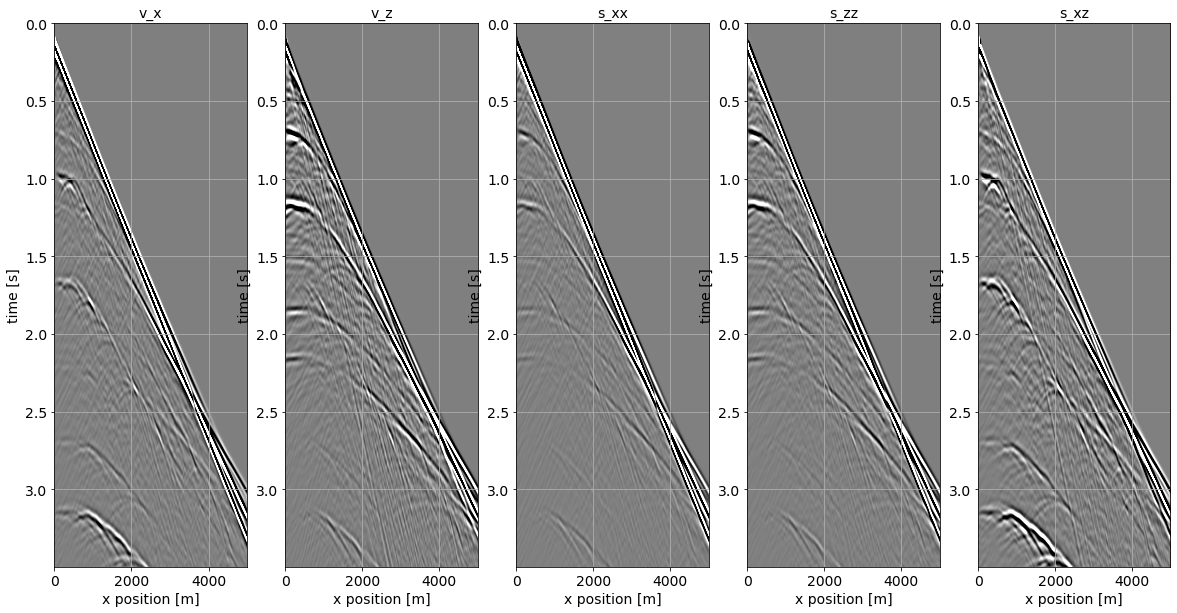

In [32]:
#plot all wfld componenets of first shot
plt.figure(figsize=(20,10))
wfld_list = ['v_x','v_z','s_xx','s_zz','s_xz']
for i in np.arange(5):
    plt.subplot(1,5,i+1), plt.title(wfld_list[i])

    clipVal = np.percentile(np.absolute(data_sep.getNdArray()[0,i,...]),96.0)

    plt.imshow(data_sep.getNdArray()[0,i,...].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nts-1)*dts, ot),
              interpolation="spline16",vmin=-clipVal,vmax=clipVal)
    plt.xlabel("x position [m]"), plt.ylabel("time [s]")
    ax = plt.gca()
    ax.grid()

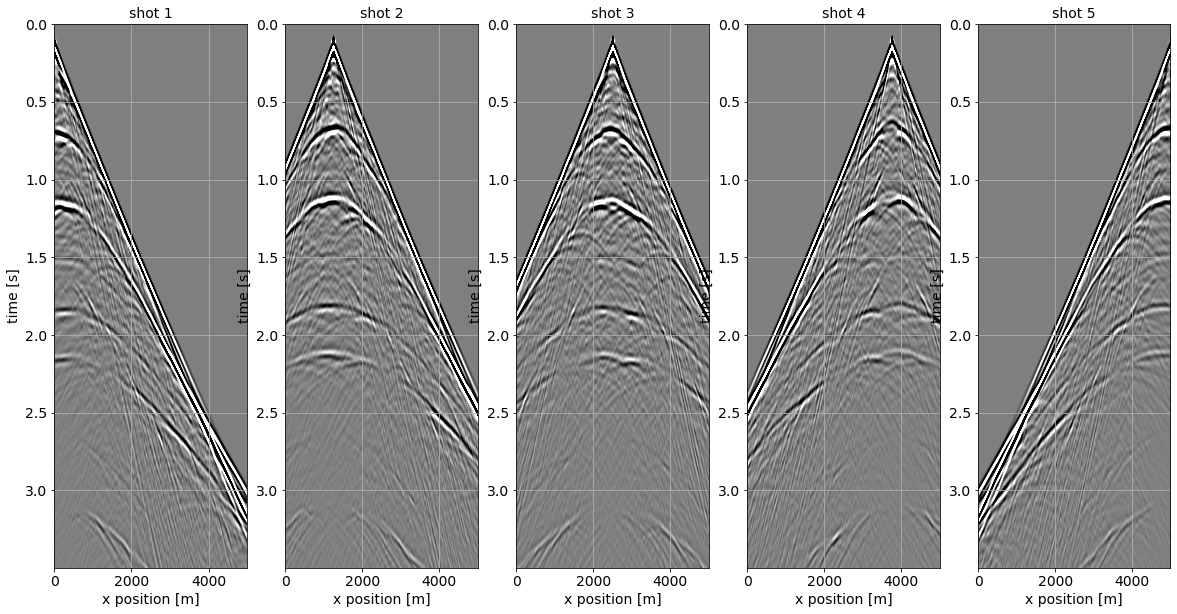

In [33]:
#plot vz componenet of all shots
plt.figure(figsize=(20,10))
for i in np.arange(5):
    plt.subplot(1,5,i+1), plt.title('shot '+str(i+1))

    clipVal = np.percentile(np.absolute(data_sep.getNdArray()[i,1,...]),96.0)

    plt.imshow(data_sep.getNdArray()[i,1,...].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nts-1)*dts, ot),
              interpolation="spline16",vmin=-clipVal,vmax=clipVal)
    plt.xlabel("x position [m]"), plt.ylabel("time [s]")
    ax = plt.gca()
    ax.grid()